# Cygnus X-1

In this notebook, we study the asymmetric kick neccesary to reproduce current observational estimates of the well-known X-ray binary Cygnus X-1.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Brief resumé

Cygnus is currently believe to host a massive black hole (BH) of $M_{\rm BH} \sim$ 21 M$_\odot$, orbiting around a non-degenerate companion star of $M_2 \sim$ 40 M$_\odot$ with an orbital period of $P_{\rm orb} = $ 5.4 d in an almost circular orbit ($e = $ 0.0019).

It has recently been proposed that the system has a spin-orbit misalignment such that the inclination between the
spin of the BH ($S_{\rm BH}$ and the orbital angular momentum ($J$) is $i \sim$ 17 $-$ 33 deg.

## About this work

Here we plan to understand what could have been the conditions at the formation of the BH (during the core collapse of its progenitor star) to produce such misalignment between the spin of the BH and the orbit.

In order to carry this analysis, we use a Markov chain Monte Carlo approach to infer the distributions of different stellar parameters needed to form a binary like Cygnus X-1. We begin our study by recognizing all the free parameters in the study, separated by when they are obtained:

- Before core-collapse:
    - $M_{\rm 1, pre-CC}$: mass of the collapsing star,
    - $M_2$: mass of the companion star,
    - $P_{\rm orb, pre-CC}$: orbital period.

- At core collapse:
    - $w$: strength of the associated kick (a value of 0 is known as Blaauw kick, occurs in the plane of the orbit),
    - $\theta$: polar angle of the kick,
    - $\phi$: azimuthal angle of the kick.

- After core-collapse:
    - $P_{\rm orb, post-CC}$: orbital period,
    - $e_{\rm post-CC}$: eccentricity,
    - $\cos \, i$: cosine of the inclination between the pre & post collapse orbits,
    - $v_{\rm sys}$: systemic velocity of the binary.
    
Thus, we have 10 parameters some of which can be compared to values derived from observations ($M_2$, $P_{\rm orb, post-CC}$, $e_{\rm post-CC}$, $\cos \, i$, $v_{\rm sys}$). The rest of the parameters must be inferred, and we will use a Bayesian approach for that.

We need to construct a likelihood based on the parameters that can be compared to observational data and infer the (posterior) distribution of the unknown parameters based on some initial estimation (prior distribution).


Our assumptions are:

- A gaussian (`norm`) distribution for the likelihoods on $P_{\rm orb, pre-CC}$, $M_2$, $v_{\rm sys}$ and $i$; and a uniform (`uniform`) distribution for $e$.

- The kick ($w$, $\theta$, $\phi$) is assumed isotropic and uniform between 0 $-$ 500 km s$^{-1}$.

- As the conditions before the core-collapse are extremely unknown, we allow for a wide range of values for $M_{\rm 1, pre-CC}$ and $P_{\rm orb, pre-CC}$.

- Current measurement have not changed since the core collapse event (reasonable, changing the direction of the spin of the BH is very difficult.
- Thus, we do not follow the evolution of orbital parameters from the collapse stage until nowadays.

---

## Running the model

We develop a tool that uses the python module `emcee` for the exploration of the parameter space with all the assumptions described earlier.

In order to use it, we provide...

Once installed every dependency, there are some parameters to change in the file `config.yml`. After that,the code is executed by running `make run` in a terminal and producing a file in HDF5 format.

In [2]:
# reserve for running the MCMC chain

---

## Import packages

In [3]:
from pathlib import Path
from typing import Any, Union

import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import poskiorb
import yaml

from mcmc.likelihood import log_likelihood

plt.style.use("style.mpl")

## Useful functions

In [4]:
def load_yaml(fname: Union[str, Path]) -> Any:
    """Load configuration file with YAML format

    Parameters
    ----------
    fname : `str / Path`
        YAML filename

    Returns
    -------
    `yaml.load`
    """

    if isinstance(fname, Path):
        fname = str(fname)

    with open(fname) as f:
        return yaml.load(f, Loader=yaml.FullLoader)

## Load data

In [5]:
CONFIG_FILENAME = "config.yml"
config = load_yaml(fname=CONFIG_FILENAME)

# set some constant values
nwalkers = config["MCMC"].get("walkers")
ndim = config["MCMC"].get("dimension")
nburn = config["MCMC"].get("burn")
nsteps = config["MCMC"].get("steps")
filename = config["MCMC"].get("filename")
priorsD = config["MCMC"].get("priorDistributions")
# Cygnus X-1 properties
stellarParameters = config["StellarParameters"]

# load samples & remove burned steps
reader = emcee.backends.HDFBackend(filename, read_only=True)
samples = reader.get_chain()[nburn:,:,:].reshape(nwalkers*(nsteps-nburn),ndim)

# to make plots we don't need more than 10 000 samples
samples_r = samples[np.random.choice(samples.shape[0], 10000, replace=False),:]
print("samples shape:", samples_r.shape)

samples shape: (10000, 6)


## Append more data, for the post core-collapse binaries

This step is needed to produce posteriors of the quantities derived from observations.

For this, we use some utilities of the `poskiorb` module that computes orbital parameters in a binary that receives a momentum kick

In [6]:
kwargs = dict()
kwargs.update(stellarParameters)
kwargs.update(priorsD)

samples2 = []

# evaluate kicks model
for k in range(len(samples_r)):

    # replace values of theta and phi outside of boundaries: 0 < theta < pi, and 0 < phi < 2 * pi
    theta = samples_r[k, 4]
    phi = samples_r[k,5] % (2 * np.pi)

    samples_r[k,5] = phi
    if theta < 0 or theta > np.pi:
        theta = np.pi - (theta % np.pi)
    samples_r[k,4] = theta

    # compute new orbit after kick
    (
        a_post,
        p_post,
        e,
        cos_i,
        v_sys,
        _,
        _,
        _,
        _,
    ) = poskiorb.utils.binary_orbits_after_kick(
        a=poskiorb.utils.P_to_a(samples_r[k, 0], samples_r[k, 1], samples_r[k, 2]),
        m1=samples_r[k, 1],
        m2=samples_r[k, 2],
        m1_remnant_mass=21,
        w=samples_r[k, 3],
        theta=samples_r[k, 4],
        phi=samples_r[k, 5],
        ids=np.ones(1),
    )

    # patch for unbounded binaries
    if len(e) == 0:
        continue
    
    # compute likelihood
    args = [samples_r[k, 0], samples_r[k, 1], samples_r[k, 2], samples_r[k, 3], samples_r[k, 4], samples_r[k, 5]]
    ll = log_likelihood(args, **kwargs)
    
    if not np.isfinite(ll):
        continue

    samples2.append([float(p_post), float(e), np.rad2deg(np.arccos(float(cos_i))), float(v_sys), ll])

# use numpy arrays
samples_post = np.asarray(samples2)
print("samples post-CC shape:", samples_post.shape)

samples post-CC shape: (4972, 5)


---

## Results on stellar parameters at core-collapse

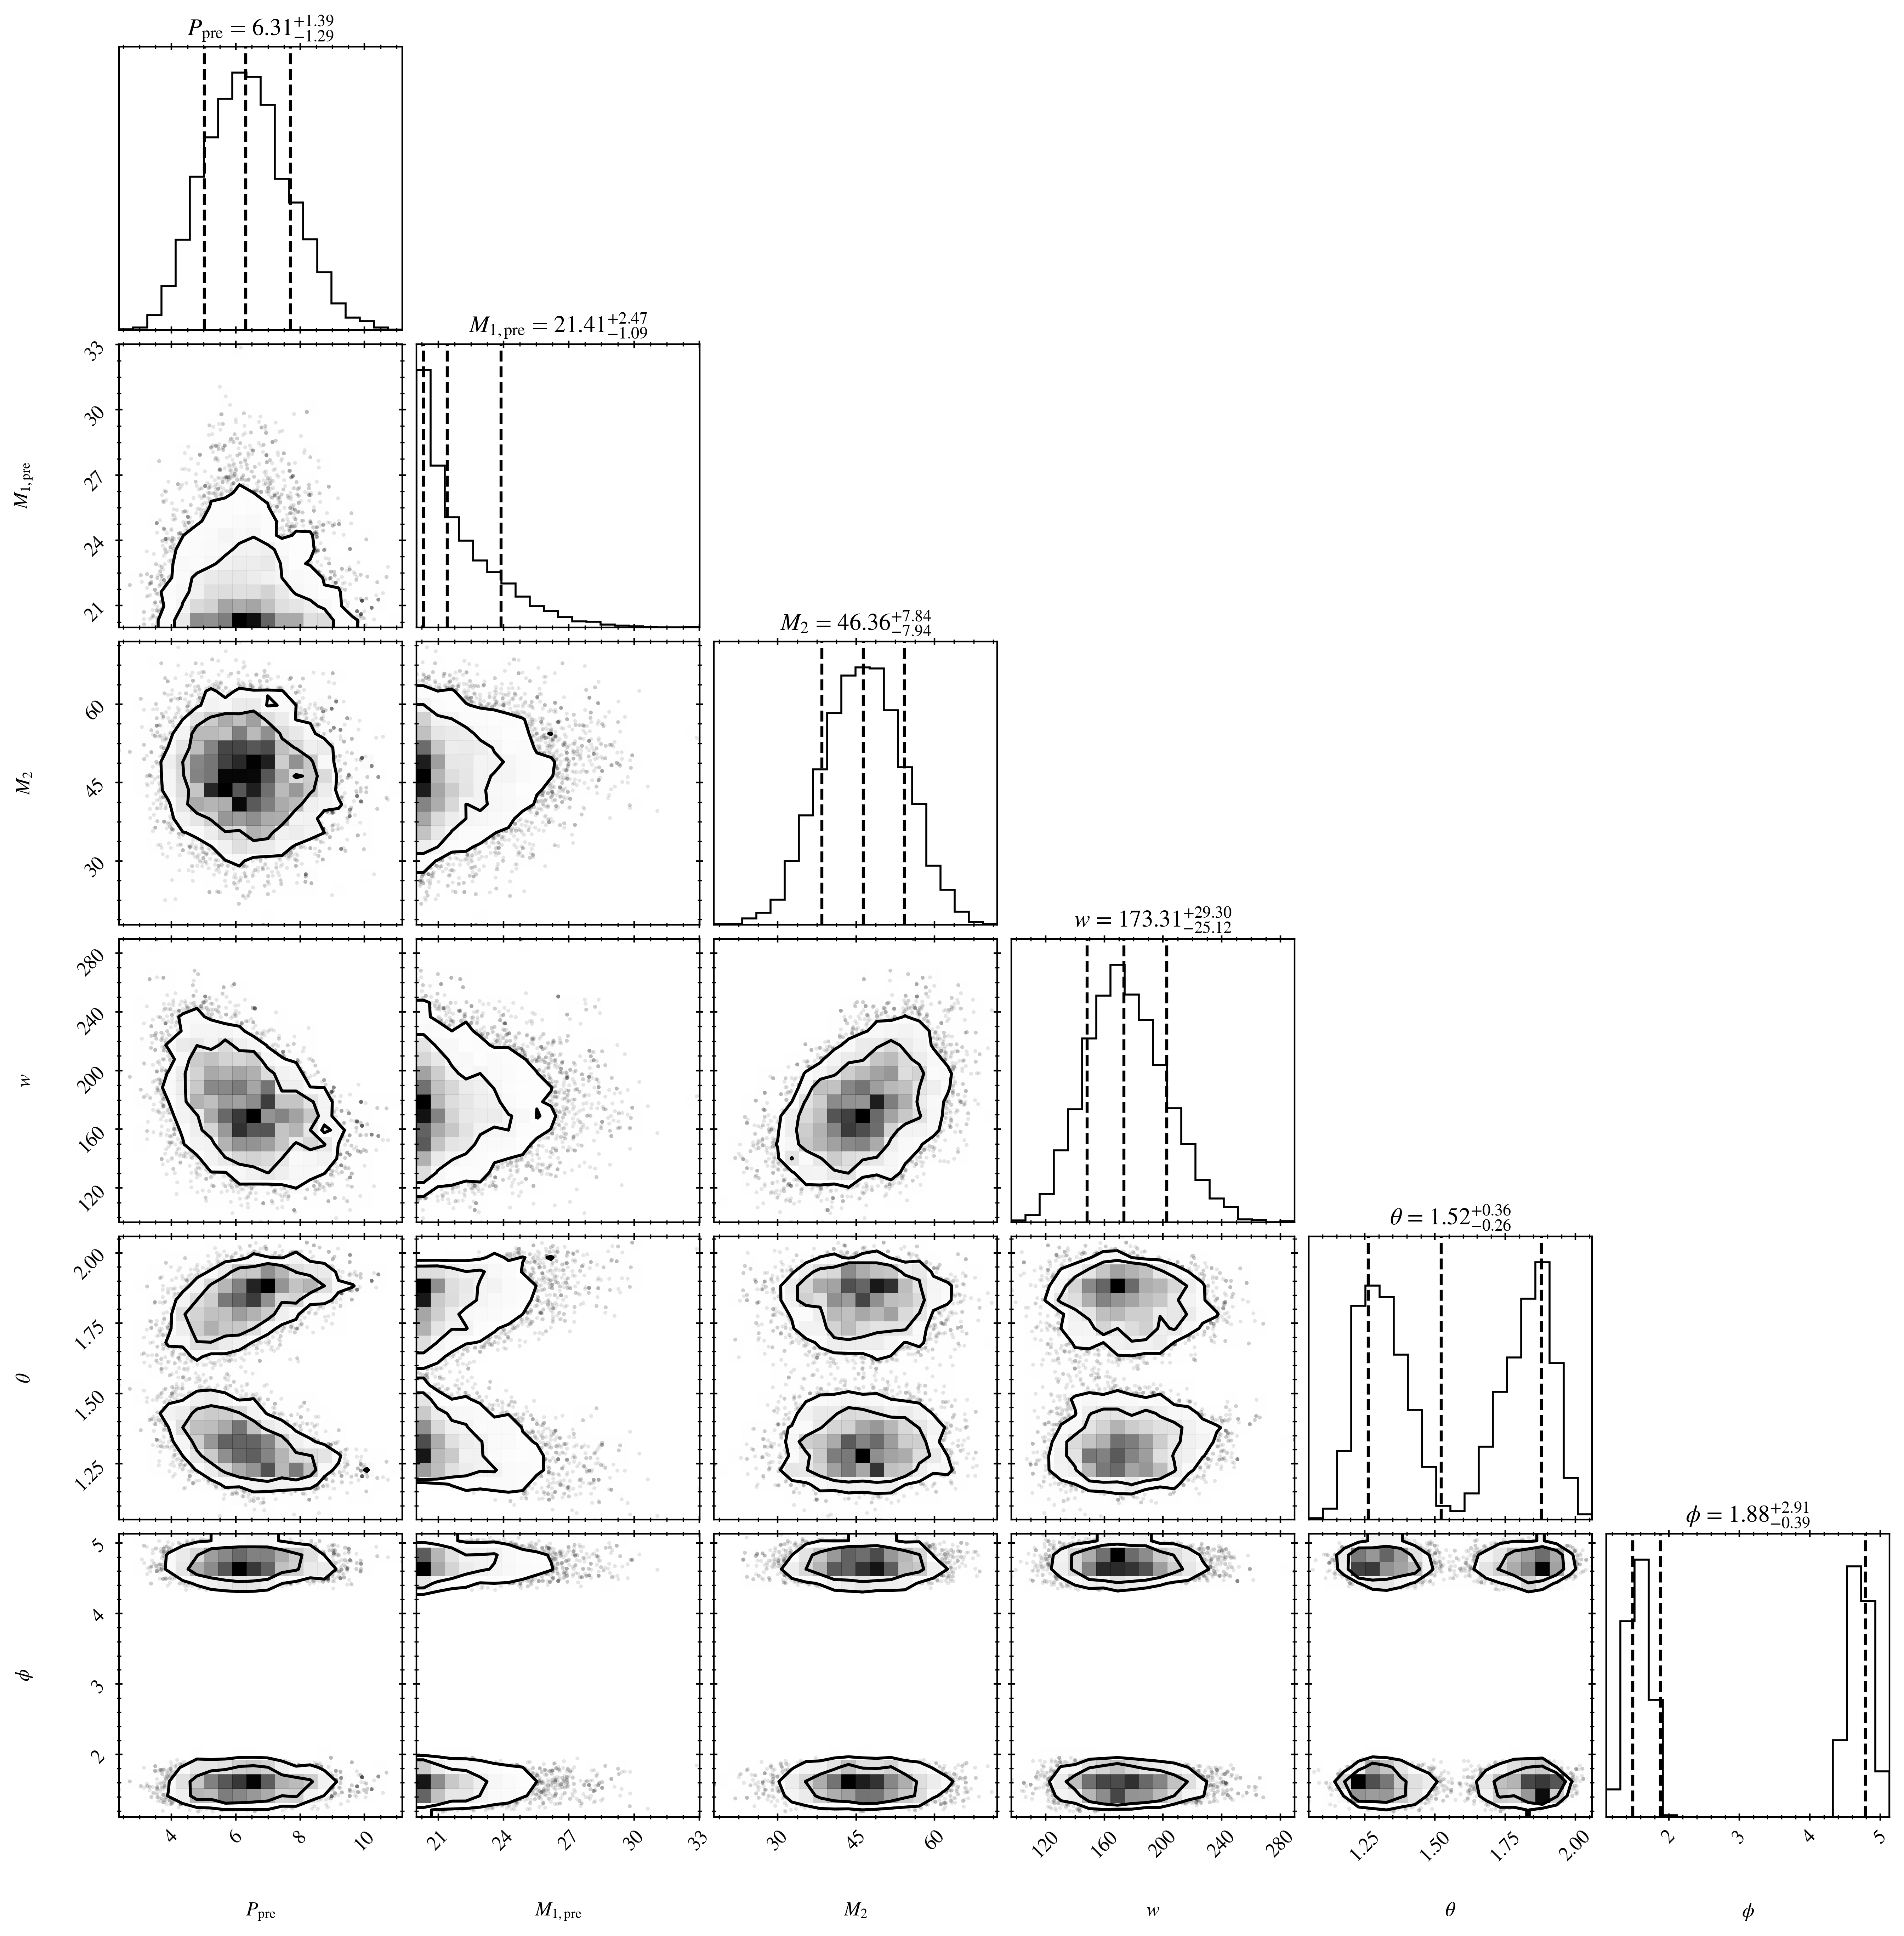

In [7]:
plt.style.use("style.mpl")

figure = corner.corner(
    samples_r,
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.90),
    labels=[
        "$P_{\\rm pre}$",
        "$M_{\\rm 1, pre}$",
        "$M_2$",
        "$w$",
        "$\\theta$",
        "$\\phi$",
    ],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
plt.savefig("pre_cc.png", dpi=200)

For a comparison, the orbital velocity just before the formation of the compact object is

In [8]:
# some useful constants
standard_cgrav, Msun, Rsun = 6.67428e-8, 1.9892e33, 6.9598e10

# mean values found in MCMC
m1_pre = np.mean(samples_r[:,1])
m2     = np.mean(samples_r[:,2])
a_pre  = poskiorb.utils.P_to_a(np.mean(samples_r[:,0]), m1_pre, m2)

# orbital velocity before collapse
v_pre = np.sqrt(standard_cgrav * (m1_pre + m2) * Msun / a_pre / Rsun)
v_pre /= 1e5
print(f"v_orb [km s-1] = {v_pre:.2f}")

v_orb [km s-1] = 469.91


## Results on stellar parameters after core-collapse

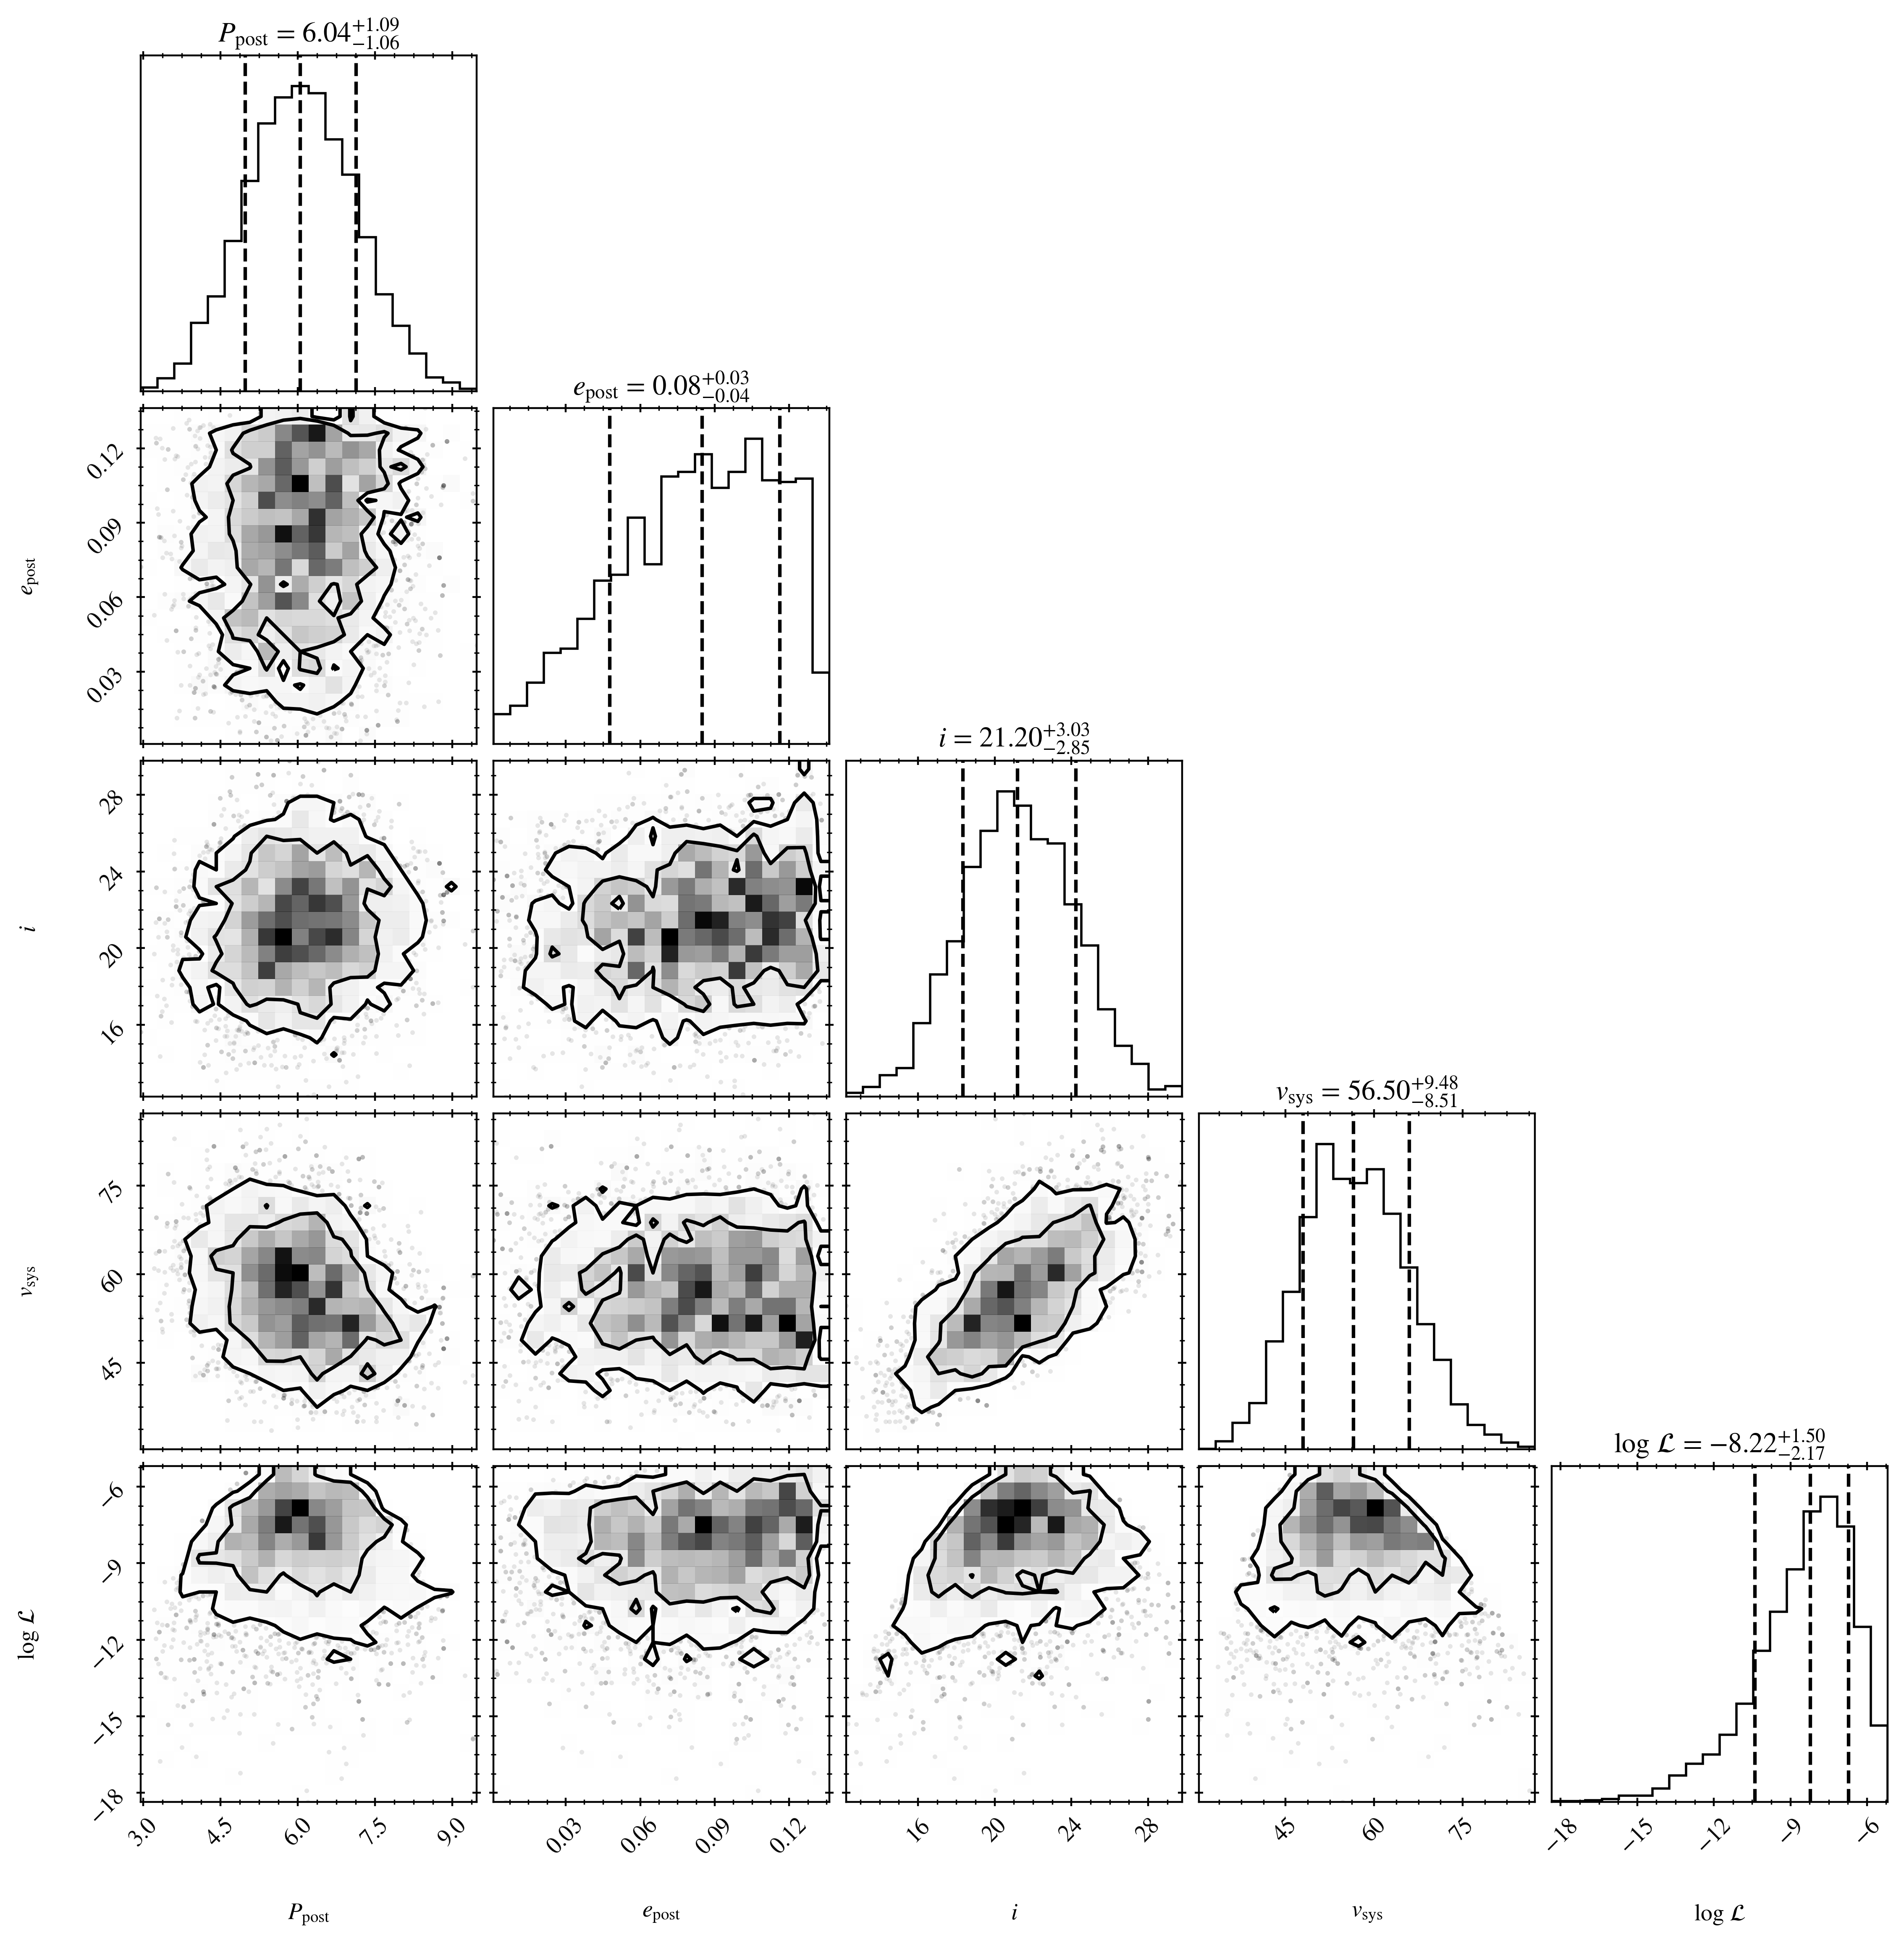

In [9]:
figure = corner.corner(
    samples_post,
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.90),
    labels=[
        "$P_{\\rm post}$",
        "$e_{\\rm post}$",
        "$i$",
        "$v_{\\rm sys}$",
        "$\log\,\mathcal{L}$"
    ],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

We see regions that will very likely produce a binary as Cygnus X-1. Let's check this using the `poskiorb` module

In [10]:
# stellar parameters at core-collapse
m1_pre, m2, porb_pre, MBH = 21.38, 46.75, 6.30, 21.00
w = [173.59 - 25.39, 173.59, 173.59 + 29.67]
theta = [1.55 - 0.29, 1.55, 1.55 + 0.32]
phi = [1.89 - 0.40, 1.89, 1.89 + 2.90]

for k in range(len(w)):
    (
        a_post, p_post, e, cos_i, v_sys,
        _, _, _, _,
    ) = poskiorb.utils.binary_orbits_after_kick(
        a=poskiorb.utils.P_to_a(porb_pre, m1_pre, m2),
        m1=m1_pre,
        m2=m2,
        m1_remnant_mass=MBH,
        w=w[k],
        theta=theta[k],
        phi=phi[k],
        ids=np.ones(1),
    )
    print(
        f"w [km s-1] = {w[k]:.2f}, theta = {theta[k]:.2f}, phi = {phi[k]:.2f} => "
        f"P_orb [d] = {float(p_post):4>0.2f}, e = {float(e):.2f}, "
        f"i = {np.rad2deg(np.arccos(float(cos_i))):.2f}, v_sys [km s-1]= {float(v_sys):.2f}"
    )

w [km s-1] = 148.20, theta = 1.26, phi = 1.49 => P_orb [d] = 10.76, e = 0.30, i = 15.24, v_sys [km s-1]= 45.42
w [km s-1] = 173.59, theta = 1.55, phi = 1.89 => P_orb [d] = 8.17, e = 0.19, i = 19.15, v_sys [km s-1]= 53.80
w [km s-1] = 203.26, theta = 1.87, phi = 4.79 => P_orb [d] = 5.77, e = 0.07, i = 25.23, v_sys [km s-1]= 63.56
